In [0]:
## Pandas && file procressing packages
import pandas as pd
from lxml import objectify
import re
import numpy as np
# importing matplotlib 
import matplotlib.pyplot as plt

##Named Entity Recognition packages
import nltk
from nltk import ne_chunk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
nltk.download('punkt')
import spacy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:

#File parsing code
path_to_xml = 'archives_berberes_v2.xml'
key_words = [' AZREF', 'AZREE', 'AZREI', 'AZEF', 'AZRF', 'AZHHI']

def xml_to_df(xml):
    root = xml.getroot()

    document_ids = [document['id'].text for document in root.getchildren()]
    document_vols = [document['vol'].text for document in root.getchildren()]
    document_bodies = [document['body'].text for document in root.getchildren()]

    data = {'id': document_ids, 'vol': document_vols, 'body': document_bodies}
    return pd.DataFrame(data)
def split_pages(df):
    # Matches strings like "[p.12]", "[p.123]" ... which were used as page delimiters in the XML,
    split_re = r'\[p\.\d+\]'
    # Split body by page separator and explode each split item into new row
    df = pd.DataFrame(df.body.str.split(split_re).tolist(), index=df.vol).stack()
    # Use volume and page number as cols rather than indices.
    df = df.reset_index(level=[0, 1])
    # Rename newly-created columns.
    df.columns = ['vol', 'page', 'body']
    # Remove rows with empty strings
    df = df[df['body'] != '']
    return df
xml = objectify.parse(path_to_xml)
df = xml_to_df(xml)

# Split each volume into pages .. if you want to.
df = split_pages(df)

#### Our Code ######
df_vol_1_3 = df.loc[df['vol'] == '1.3']

df_name_of_tribes = df_vol_1_3[df_vol_1_3.body.str.contains('|'.join(key_words), regex=True, case=True)]
##### Last_page contains the value of the last page where laws are mentioned ######
last_page = df_vol_1_3[df_vol_1_3.body.str.contains('FIN', regex=True, case=True)].page.tolist()[0]

#### List that contains the names of all the tribes mentioned in 1.3 ####
name_of_tribes = []
#### This loop
for body in df_name_of_tribes.body.to_numpy():
    #### we split the text in 2 and we select the part after where one of the keywords was detected ####
    text_after_a_keyword = re.split('|'.join(key_words), body)[1]
    #### we select all uppercase letters after one of the keywords in order to get the tribe name while removing unecessary words and special characters
    name_of_tribe = re.split('[A-Z][a-z]+', text_after_a_keyword)[0].replace('DES ', '').replace('DE ', '').replace('--','').strip()
    name_of_tribes.append(name_of_tribe)


result = []
index_of_page = 0

for tribe in name_of_tribes:
    pages = df_name_of_tribes.page[index_of_page:index_of_page+2].tolist()
    start_page = pages[0]
    try:
        end_page = pages[1]
    except:
        end_page = last_page
    content = ''
    for i in range(start_page, end_page+1):
        content += df_vol_1_3.loc[df.page == i].body.tolist()[0]
    result.append([tribe, start_page, end_page, content])
    index_of_page += 1

#### This dataframe contains the tribe name and both the start and end page where their laws were mentioned with the respective combined bodies of those pages
df2 = pd.DataFrame(result, columns = ['Tribe Name', 'Start Page', 'End Page', 'Content'])

In [0]:
df2

,Tribe Name,Start Page,End Page,Content
0,SAHELI',3,8,\nL'AZREF DES TRIBUS ET QSOUR BERBÈRES DU HAUT...
1,TAZOI'GGART,8,9,\n— 112 —\n\nCOMPLÉMENT AU RÈGLEMENT PRÉCÉDENT...
2,QADDOUSA,9,12,"\n2. Pour le vol nocturne, l'amende est double..."
3,.F D'.U. COR'AN,12,14,\n— n6 —\n\nleur incombe et quiconque y failli...
4,AIT AZAGIIOU ',14,19,"\n—_ n8g —\n\nrieur du qsar, dans le périmètre..."
5,TOULAL,19,27,\n— 123 —\n\n53- Le d/ww/(Israélite) vendant d...
6,nS AIT IZDF.G ',27,30,\nXI AZHHI nS AIT IZDF.G '\n\nLouange à Dieu q...


In [0]:
##############################################################################
#		Editing the names of tribes + Taking only the laws from the Content	 #
##############################################################################


##Capitalizing: using title() to capitalize each single word and rstrip to remove trailing spaces or apostrophes
df2['Tribe Name'] = df2['Tribe Name'].apply(lambda x: x.title().rstrip(" \'"))

##Replacing
df2 = df2.replace(df2['Tribe Name'][1],"Tazzouggart")
df2 = df2.replace(df2['Tribe Name'][3],"Al Gor'an")
df2 = df2.replace(df2['Tribe Name'][6],"Ait Izdfeg")

#Removing the fractions
df2 = df2.replace({'1/2': '0.5', '1/4': '0.25', '1/8': '0.125' },  regex=True)


#Organizing the data
sentence_tokenizer = nltk.data.load('tokenizers/punkt/french.pickle')
def orgdata(tribe_number, df2):
    pattern = re.compile("^[\n]*[0-9]+[.]")
    # listx[0] = '1.' listx[1] = "Celui qui s'introduit pour voler, dans une maison du qsar, paye 50 metqalsd'amende."
    listx = sentence_tokenizer.tokenize(df2['Content'][tribe_number])
    tribe = df2['Tribe Name'][tribe_number]

    Law_number = []
    Law = []
    offence = []
    df = pd.DataFrame(columns=['Tribe_Name', 'Law_number', 'Law'])
   
    for x in listx:
        if pattern.match(x):
            Law_number.append(x)
        else:
            Law.append(x)

    df.Law = pd.Series(Law)
    df.Law_number = pd.Series(Law_number)
    df.loc[:,'Tribe_Name'] = tribe
    
    return df




In [0]:
##########################
## Getting the currency ##
##########################

i = 0
sumt = 0 
d =[]
offence = []
tribe_name = ""
while i < len(df2):
    test = orgdata(i, df2)
    currencyRegex = re.compile(r'\d+(\.\d+)? (mitqal|metqal|ouqias|ouqgias|réal|réaux|douro|douros|ouqia|moud|mouds|dirhem|dirhems|metqalsd|metqals|mouzounas)')
    lines = test.Law
    tribe_name = df2['Tribe Name'][i]
    i = i + 1
    
    for line in lines:
        mo = currencyRegex.search(line)
        if mo is None:
            d.append((tribe_name,line,mo))
            offence.append((tribe_name,line,mo))
        else:
            d.append((tribe_name,line,mo.group()))
            offence.append((tribe_name,line,mo.group()))
df3 = pd.DataFrame(d, columns=('Tribe','Law', 'Offence'))
print(df3)

for line in d:
    print(line)

##Selecting the offences
notinterested = []
for of in offence:
	if None in of:
		notinterested.append(of)

#Using list comprehension feature
offence = [x for x in offence if x not in notinterested]

df4 = pd.DataFrame(offence, columns=('Tribe','Law', 'Offence'))
#print(df4)


#get the amount and add a column to df4
amount = []
currency = []

for of in offence:
    res = of[2].split(" ")
    #Very important to set res to int! to sort it later on
    amount.append(float(res[0]))
    currency.append(res[1])

df4['Amount'] = amount
df4['Currency'] = currency

#print("\n\nView of the first 5 elements of the unsorted table: df4.head(5).\n", df4.head(5))


#Sorted table by amount .sort_values('Amount')
df5 = df4
#print("\n\nSorted table by amounts only.\n")
#print(df5.to_string())

# In[203]:

M = df5.groupby('Tribe')['Amount'].max()
m = df5.groupby('Tribe')['Amount'].min()
#sorted(, reverse= True)

#print("\n\nTribes by maximum fines: \n", M, "\n\n")
#print("\n\nTribes by minimum fines: \n", m,"\n\n")

frame = {'Maximum fines' : M, 'Minimum fines' : m}
result = pd.DataFrame(frame)


In [0]:
#####################################
## Converting to a common currency ##
#####################################

##Unifying the currencies so that real and reaux can mean the same thing
df5 = df5.replace({
                    'mitqal' : 'metqal(s)', 'metqalsd': 'metqal(s)', 'metqals' : 'metqal(s)', 'metqal': 'metqal(s)',
                    'dirhems' : 'dirhem','dirhem' : 'dirhem(s)',
                    'mouds' : 'moud', 'moud' : 'moud(s)',
                    'ouqias' : 'ouqia', 'ouqia' : 'ouqia(s)', 'ouqgias' : 'ouqia(s)',
                    'réal' : 'réal/réaux', 'réaux': 'réal/réaux',
                    'douros' : 'douro', 'douro': 'douro(s)',
                    'mouzounas' : 'mouzouna', 'mouzouna': 'mouzouna(s)'}, regex = True)

#Differenciating between types of currency: coinage (douro, real, dirhem) vs. barter barter system (moud, ouqia, mouzouna)
typex = []
coinage = ["dirhem(s)", "réal/réaux", "douro(s)"]

for x in df5['Currency']:
    if x in coinage:
        typex.append("Coinage")
    else:
        typex.append("Barter")

#print(typex)
df5['Type'] = typex
#print(df5.to_string())


##Converted currency
MAD = []

factorsDict = { 'dirhem(s)'     :   1.26,
                'réal/réaux'    :   0.05,
                'douro(s)'      :   0.05,
                'metqal(s)'     :   400,
                'moud(s)'       :   1,
                'ouqia(s)'      :   40,
                'mouzouna(s)'   :   1}

for idx, x in enumerate(df5['Currency']):
    converted = float(factorsDict[x])*df5['Amount'][idx]
    MAD.append(converted)

df5['MAD'] = MAD


In [0]:
df5

,Tribe,Law,Offence,Amount,Currency,Type,MAD
0,Saheli,"Celui qui s'introduit pour voler, dans une mai...",50 metqal(s),50.0,metqal(s),Barter,20000.000
1,Saheli,Si un vol est commis dans un troupeau et que l...,50 metqal(s),50.0,metqal(s),Barter,20000.000
2,Saheli,"Celui qui, en quelque lieu que ce soit, fût-ce...",1 réal/réaux,1.0,réal/réaux,Coinage,0.050
3,Saheli,Celui qui cueille un ou plusieurs régimes de d...,1 réal/réaux,1.0,réal/réaux,Coinage,0.050
4,Saheli,"Celui qui vole de la luzerne, des céréal/réaux...",0.5 réal/réaux,0.5,réal/réaux,Coinage,0.025
...,...,...,...,...,...,...,...
196,Ait Izdfeg,"Quiconque vole de la luzerne, ou des fèves, ou...",5 metqal(s),5.0,metqal(s),Barter,2000.000
197,Ait Izdfeg,Celui qui s'enfuit avec une femme dont lés cri...,500 metqal(s),500.0,metqal(s),Barter,200000.000
198,Ait Izdfeg,Celui qui ravit une femme mariée : 400 metqal(...,400 metqal(s),400.0,metqal(s),Barter,160000.000
199,Ait Izdfeg,"S'il s'agit d'une femme sans mari, veuve ou je...",200 metqal(s),200.0,metqal(s),Barter,80000.000


In [0]:
print("\n\n", df5.to_string())

119 82


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e76b43f28>],
      dtype=object)

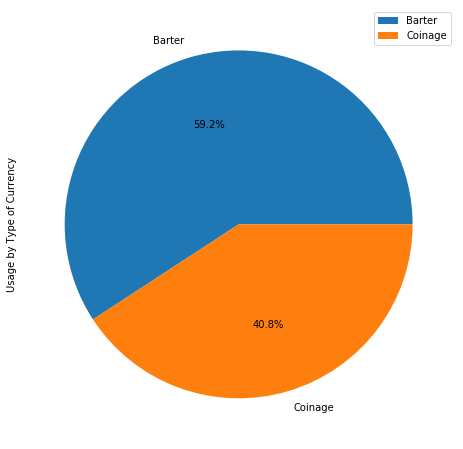

In [0]:
count_Barter= df5.Type.value_counts()['Barter']
count_Coinage= df5.Type.value_counts()['Coinage']

print(count_Barter,count_Coinage)

# --- dataset 1: just 4 values for 4 groups:
df7 = pd.DataFrame([count_Barter, count_Coinage], index=['Barter','Coinage'], columns=['Usage by Type of Currency'])
 
# make the plot
df7.plot(kind='pie', subplots=True, figsize=(8, 8),autopct='%1.1f%%')



In [0]:
df6 = df5[['Currency','MAD']].copy()
df6 = pd.DataFrame (df6.groupby(['Currency'])['MAD'].agg('sum'))
df6

,MAD
Currency,
dirhem(s),5.040
douro(s),11.175
metqal(s),1216400.000
moud(s),64.500
mouzouna(s),54.000
ouqia(s),4600.000
réal/réaux,10.325


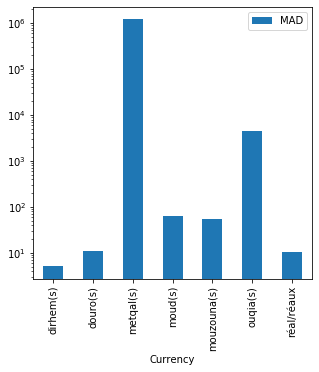

In [0]:
df6.plot.bar(y='MAD', figsize=(5, 5), logy=True)

In [0]:
nlp = spacy.load('fr_core_news_sm')

In [0]:

def adder(stag, start, end):
    stringy = ""
    for i in range(start, end+1):
        stringy = stringy + " " + stag[i].text

    return stringy

In [0]:
def quiCASE(tags, i):
    for j in range(i, len(tags)):
        if tags[j].text == "qui":   
            #cas virgule
            if tags[j+1].pos_ == "AUX":
                if tags[j+2].pos_ == "VERB":
                    if tags[j+3].pos_ == "ADP":
                        if tags[j+4].pos_ == "DET":
                            if tags[j+5].pos_ == "NOUN" and tags[i+5].text != "amende":
                                if tags[j+6].pos_ == "VERB":
                                    if tags[j+7].pos_ == "DET":
                                        if tags[j+8].pos_ == "NOUN":
                                            return adder(tags, j+1, j+8)



            elif  tags[j+1].text == ",":

                shift = 0
                for a in range(i,len(tags)):
                    if tags[a].text == ",":
                        if tags[a+1].pos_ == "VERB":
                            if tags[a+2].pos_ == "DET":
                                if tags[a+3].pos_ == "NOUN" or tags[a+3].pos_ == "PRON":
                                    return adder(tags, a+1, a+3)

                        elif tags[a+1].tag_ == "ADV__Polarity=Neg":
                            shift = a+1

                            for e in range(a+2, len(tags)):
                                if tags[e].tag_ == "ADV__Polarity=Neg":
                                    shift = e
                                    break

                            if tags[shift+1].pos_ == "DET":  #y
                                if tags[shift+2].pos_ == "NOUN": #a ==> S'il n'y a: if there is
                                    return adder(tags, a+1, shift+2)


                return str("NULL")

            elif tags[j+1].tag_ == "ADV__Polarity=Neg":
                shift = j+1

                for a in range(j+2, len(tags)):
                    if tags[a].tag_ == "ADV__Polarity=Neg":
                        shift = a
                        break

                if tags[a+1].pos_ == "ADP":  #y
                    if tags[a+2].pos_ == "DET": #a ==> S'il n'y a: if there is
                        if tags[a+3].pos_ == "NOUN": 
                            return adder(tags, j+1, a+3)


            elif tags[j+1].pos_ == "PRON":
                if tags[j+2].pos_ == "VERB":
                    if tags[j+3].pos_ == "ADP":
                        if tags[j+4].pos_ == "VERB":
                            return adder(tags, j+1, j+4)

                        elif tags[j+4].pos_ == "DET":
                            if tags[j+5].pos_ == "NOUN" or tags[j+5].pos_ == "PROPN":
                                return adder(tags, j+1, j+5)

                        else:
                            return adder(tags, j+1, j+2)

                    
                    elif tags[j+3].pos_ == "NOUN":
                        return adder(tags, j+1, j+3)

                    else:
                        return adder(tags, j+1, j+2)


            elif tags[j+1].pos_ == "VERB" or tags[j+1].pos_ == "ADJ":
                if tags[j+2].pos_ == "DET":
                    if tags[j+3].pos_ == "CCONJ": #CCONJ = coordinating conjunction
                        if tags[j+4].pos_ == "DET":
                            if tags[j+5].pos_ == "NOUN":
                                return adder(tags, j+1, j+5)

                    elif tags[j+3].pos_ == "PROPN" or  tags[j+3].pos_ == "PRON":
                        return adder(tags, j+1,j+3)

                    elif tags[j+3].pos_ == "NOUN":
                        if tags[j+4].pos_ == "ADP":
                            if tags[j+5].pos_ == "NOUN":
                                return adder(tags, j+1, j+5)

                        elif tags[j+4].pos_ == "VERB":
                            return adder(tags, j+1, j+4)

                        else:
                            return adder(tags, j+1, j+3)

                    
                elif tags[j+2].text == "(" and tags[j+2].pos_ == "PUNCT":
                    shift = 0
                    for a in range(j+3, len(tags)):
                        if tags[a].text == ")" and tags[a].pos_ == "PUNCT":
                            shift = a
                            break

                    if tags[shift+1].pos_ == "CCONJ" or tags[shift+1].pos_ == "DET":
                        if tags[shift+2].pos_ == "NOUN" or tags[shift+2].pos_ == "PROPN":
                            return (adder(tags, i+1, i+1) + adder(tags, shift+1, shift+2))

                elif tags[j+2].pos_ == "SCONJ":
                    if tags[j+3].pos_ == "PRON":
                        return adder(tags, j+1, j+3)

                elif tags[j+2].pos_ == "ADP":
                    if tags[j+3].pos_ == "DET" or  tags[j+3].pos_ == "PRON" :
                        if tags[j+4].pos_ == "PROPN" or tags[j+4].pos_ == "NOUN" or tags[j+4].pos_ == "VERB":
                            return adder(tags, j+1, j+4)

                    elif tags[j+3].pos_ == "VERB":
                        if tags[j+4].pos_ == "DET":
                            if tags[j+5].pos_ == "NOUN":
                                return adder(tags, j+1, j+5)

                    elif tags[j+3].pos_ == "PROPN" :
                        return adder(tags, j+1, j+3)

                elif tags[j+2].pos_ == "VERB":
                    if tags[j+3].pos_ == "ADP":
                        if tags[j+4].pos_ == "DET":
                            if tags[j+5].pos_ == "NOUN" or tags[j+5].pos_ == "PRON":
                                return adder(tags, j+1, j+5)


            elif tags[j+1].pos_ == "ADJ":
                shift = 0
                if tags[j+2].text == "(" and tags[j+2].pos_ == "PUNCT":
                    for j in range(j, len(tags)):
                        if tags[j].text == ")":
                            shift = j
                            break

                    if tags[shift+i].pos_ == "DET":
                        if  tags[shift+i+1].pos_ == "PROPN":
                            PotentialOff = adder(tags, j+1, j+1) + adder(tags, shift+i, shift+i+1)
                            return adder(tags, j+1, j+5)

            elif tags[j+1].pos_ == "ADP":
                if tags[j+2].pos_ == "ADP":
                    if tags[j+3].pos_ == "VERB":
                        return adder(tags, j+1,j+3)

    return str("NULL")




In [0]:
def offencegetter(x):

    specialSMBdict = {  '«' : '»',
                        '»' : 'NULL'}

    tags = nlp(x)
    PotentialOff = ""

    #for word in tags:
    #   print(word.text, word.pos_,word.tag_)


    i=0

    ## IN CASE THERE IS A SPACE
    for j in range(0, len(tags)):
        if tags[j].text == "Quiconque" or tags[j].text == "S'":
            j = i
            break

    ##Sentences that are constructed specifically:
    if tags[i].text == "Quiconque":
        if tags[i+1].pos_ == "VERB":
            if tags[i+2].pos_ == "ADP":
                if tags[i+3].pos_ == "DET":
                    if tags[i+4].pos_ == "NOUN" or tags[i+4].pos_ == "PRON":
                        return adder(tags, i+1, i+4)

                elif tags[i+3].pos_ == "VERB":
                    return adder(tags, i+1, i+3)

            elif tags[i+2].pos_ == "DET":
                if tags[i+3].pos_ == "PROPN" or tags[i+3].pos_ == "NOUN" and tags[i+3].text not in specialSMBdict:
                    return adder(tags, i+1, i+3)

                else:
                    return adder(tags, i+1, i+1)

        elif tags[i+1].pos_ == "PROPN":
            if tags[i+2].pos_ == "DET":
                if tags[i+3].pos_ == "NOUN":
                    if tags[i+4].pos_ == "ADJ":
                        return adder(tags, i+1, i+4)
                    else:
                        return adder(tags, i+1, i+3)

        elif tags[i+1].pos_ == "NOUN":
            if tags[i+2].pos_ == "ADP":
                if tags[i+3].pos_ == "DET":
                    if tags[i+4].pos_ == "PROPN":
                        return adder(tags, i+1, i+4)


    elif tags[i].text == "S'":
        if tags[i+1].pos_ == "PRON":  #il
            if tags[i+2].pos_ == "PRON":  #y
                if tags[i+3].pos_ == "AUX": #a ==> S'il y a: if there is
                    if tags[i+4].pos_ == "ADV":
                        if tags[i+5].pos_ == "VERB":
                            if tags[i+6].pos_ == "CCONJ":
                                if tags[i+7].pos_ == "NOUN":
                                    if tags[i+8].pos_ == "ADJ":
                                        return adder(tags, i+4, i+8)
                            else:
                                return adder(tags, i+4, i+5)

            elif tags[i+2].tag_ == "ADV__Polarity=Neg":  #n'
                if tags[i+3].pos_ == "PRON":  #y
                    if tags[i+4].pos_ == "VERB": #a ==> S'il n'y a: if there is
                        if tags[i+5].tag_ == "ADV__Polarity=Neg": #pas
                            if tags[i+6].pos_ == "DET":
                                if tags[i+7].pos_ == "NOUN":
                                    return adder(tags, i+2, i+7)

                elif tags[i+3].pos_ == "ADJ":
                    if tags[i+4].tag_ == "ADV__Polarity=Neg":
                        return adder(tags, i+2, i+4)


    #Check if there is any QUI in the sentence
    #SCONJ
    if tags[i].pos_ != "SCONJ" and tags[i+1].pos_ != "DET" and tags[i+2].pos_ != "NOUN" and tags[i+3].pos_ != "AUX":
        for i in range(0, len(tags)):
            if tags[i].text.lower() == "qui":
                PotentialOff = quiCASE(tags, i)
                if PotentialOff != "NULL":
                    return quiCASE(tags, i)



    #The first word is always irrelevant
    for i in range(0, len(tags)):
        #negation cases
        if tags[i].tag_ == "ADV__Polarity=Neg":
            shift = 0
            for j in range(i+1,len(tags)):
                if tags[j].tag_ == "ADV__Polarity=Neg":
                    shift = j
                    break

            return adder(tags, i, shift+1)

        elif tags[i].text == "(" and tags[i].pos_ == "PUNCT":
            #print("320")

            shift = 0
            for j in range(i+1, len(tags)):
                if tags[j].text == ")" and tags[j].pos_ == "PUNCT":
                    shift = j
                    break

            if tags[j+1].pos_ == "PRON":
                if tags[j+2].pos_ == "VERB":
                    if tags[j+3].pos_ == "ADJ":
                        if tags[j+4].pos_ == "ADJ":
                            if tags[j+5].pos_ == "NOUN":
                                return adder(tags, j+1, j+5)
                    else:
                        return adder(tags, j+1, j+2)
            
            elif tags[j+1].pos_ == "VERB":
                return adder(tags, j+1, j+1)

        
        elif tags[i].text == "," and tags[i].pos_ == "PUNCT":
            shift = 0
            for j in range(i,len(tags)):
                if tags[j].text == ",":
                    if tags[j+1].pos_ == "VERB":
                        if tags[j+2].pos_ == "DET":
                            if tags[j+3].pos_ == "NOUN" or tags[j+3].pos_ == "PRON":
                                return adder(tags, j+1, j+3)

                    elif tags[j+1].pos_ == "PRON":
                        if tags[j+2].pos_ == "ADV":
                            return adder(tags, j+1, j+2)

                    elif tags[j+1].pos_ == "NOUN":
                        if tags[j+2].pos_ == "CCONJ":
                            if tags[j+3].pos_ == "DET":
                                if tags[j+4].pos_ == "NOUN":
                                    return adder(tags, j+1, j+4)


                    elif tags[j+1].tag_ == "ADV__Polarity=Neg":

                        shift = j+1

                        for a in range(j+2, len(tags)):
                            if tags[a].tag_ == "ADV__Polarity=Neg":
                                shift = a
                                break

                        if tags[a+1].pos_ == "DET":  #y
                            if tags[a+2].pos_ == "NOUN": #a ==> S'il n'y a: if there is
                                return adder(tags, j+1, a+2)




        
        elif tags[i].text.lower() == "pour":
            if tags[i+1].pos_ == "DET":
                if tags[i+2].pos_ == "NOUN":
                    if tags[i+3].pos_ == "VERB":
                        return adder(tags, i+1, i+3)


        elif tags[i].pos_ == "NOUN" :
            if tags[i+1].pos_ == "ADP":
                if tags[i+2].pos_ == "NOUN":
                    if tags[i+3].pos_ == "ADP":
                        if tags[i+4].pos_ == "VERB":
                            if tags[i+5].pos_ == "DET" or tags[i+5].pos_ == "PROPN":
                                if tags[i+6].pos_ == "NOUN" or tags[i+6].pos_ == "PRON":
                                    return adder(tags, i, i+6)

                                elif tags[i+6].pos_ == "PUNCT":
                                    if tags[i+7].pos_ == "PRON":
                                        return adder(tags, i, i+7)



                elif tags[i+2].pos_ == "DET":
                    if tags[i+3].pos_ == "NOUN" or tags[i+3].pos_ == "DET":
                        return adder(tags, i, i+3)

            elif tags[i+1].pos_ == "DET" and tags[i+1].text not in specialSMBdict:
                if tags[i+2].pos_ == "NOUN":
                    return adder(tags, i, i+2)

            elif tags[i+1].pos_ == "VERB":
                if tags[i+2].pos_ == "CCONJ":
                    if tags[i+3].pos_ == "NOUN":
                        if tags[i+4].pos_ == "ADP":
                            if tags[i+5].pos_ == "DET":
                                if tags[i+6].pos_ == "PRON":
                                    return adder(tags, i, i+6)

            elif tags[i+1].pos_ == "NOUN" or tags[i+1].pos_ == "VERB":
                if tags[i+2].pos_ == "ADP":
                    if tags[i+3].pos_ == "DET":
                        if tags[i+4].pos_ == "NOUN":
                            return adder(tags, i, i+4)


        elif tags[i].pos_ == "SCONJ" or tags[i].pos_ == "VERB":
            if tags[i+1].pos_ == "DET":
                if tags[i+2].text in specialSMBdict:
                    shift = 0
                    for j in range(0,len(tags)):
                        if tags[j].text == specialSMBdict[tags[i+2].text]:
                            shift = j
                            break

                    return adder(tags, i, j)

                elif tags[i+2].pos_ == "NOUN":
                    if tags[i+3].pos_ == "AUX" or tags[i+3].pos_ == "PRON": #adposition
                        if tags[i+4].pos_ == "VERB":
                            if tags[i+5].pos_ == "VERB":
                                return adder(tags, i+1, i+5)

                            elif tags[i].pos_ == "VERB":
                                return adder(tags, i, i+4)

                            else:
                                return adder(tags, i+1, i+4)


                    elif tags[i].pos_ == "VERB":
                        return adder(tags, i, i+2)

                    elif tags[i+3].pos_ == "VERB":
                        return adder(tags, i+1, i+3)


                    elif tags[i+3].pos_ == "ADJ":
                        if tags[i+4].pos_ == "ADP":
                            if tags[i+5].pos_ == "NOUN":
                                return adder(tags, i+1, i+5)


                elif tags[i+2].pos_ == "PRON":
                    if tags[i+3].pos_ == "ADP":
                        if tags[i+4].pos_ == "PRON":
                            if tags[i+5].pos_ == "VERB":
                                return adder(tags, i+5, i+5)

    



            elif tags[i].pos_ == "VERB":
                if tags[i+1].pos_ == "ADP" or tags[i+1].pos_ == "ADV":
                    if tags[i+2].pos_ == "VERB":
                        if tags[i+3].pos_ == "ADP":
                            if tags[i+4].pos_ == "DET":
                                if tags[i+5].pos_ == "PRON":
                                    return adder(tags, i, i+5)

                        else:
                            return adder(tags, i, i+2)
            

            elif tags[i+1].pos_ == "NUM":
                if tags[i+2].pos_ == "NOUN":
                    if tags[i+3].pos_ == "PRON":
                        if tags[i+4].pos_ == "VERB":
                            return adder(tags, i+1, i+4)

            elif tags[i+1].pos_ == "SCONJ":
                if tags[i+2].pos_ == "DET":
                    if tags[i+3].pos_ == "NOUN":
                        if tags[i+4].pos_ == "DET":
                            if tags[i+5].pos_ == "PROPN":
                                return adder(tags, i+1, i+5)

        elif tags[i].pos_ == "DET":
            if tags[i+1].pos_ == "NOUN":
                if tags[i+2].pos_ == "ADV":
                    if tags[i+3].pos_ == "VERB":
                        return adder(tags, i+1, i+3)


    #### SPECIAL CASES:
    for spec1 in range(0, len(tags)):
        flag =  "GENERAL SPECIFICATION"

        if tags[spec1].text == "règle":
            for spec2 in range(spec1, len(tags)):
                if tags[spec2].text == "applicable":
                    return flag

        elif tags[spec1].pos_ == "NUM":
            if tags[spec1+1].text != "-":
                return flag

        elif tags[spec1].text == "délai":
            for spec2 in range(spec1, len(tags)):
                if tags[spec2].text == "imparti":
                    return flag


    return PotentialOff




In [0]:
def entitygetter(x):
    rejectvals = [  "»", "Sinon", "Quiconque", "mouzouna(s", "douro(s", "moud(s",
                     "Celui qui vole de la luzerne", "ON/(f", "moud(s)re", "— 123 —\n\n"]
    tags = nlp(x)
    entity = ""
    for ent in tags.ents:
        if ent.text not in rejectvals:
            entity = entity +"|"+  str(ent.label_) + " : " + str(ent.text)  + "|"

    return entity



In [0]:
def subjectgetter(x):
    tags = nlp(x)
    subject = []

    #classes = ["femme", "homme","nègre", "Cheikh", "femmes", "hommes", "ouqgqafs", "Brabers", "Chérif", "fqih", "reffad", "Chcikh"]
    #for word in tags:
    #   print(word.text, word.pos_,word.tag_)
    #print("\n\n\n")
    

    if tags[0].text == "Quiconque":
        subject.append("Unspecified")

    elif tags[0].text == "Celle":
        subject.append("femme")

    elif tags[0].text == "Tout":
        if tags[1].pos_ == "NOUN":
            subject.append(str(tags[1]))

    elif tags[0].pos_ == "DET":
        if tags[1].pos_ == "NOUN":
            subject.append(str(tags[1]))

    elif tags[0].text == "Si":
        if tags[1].pos_ == "DET" or tags[1].pos_ == "NUM":
            if tags[2].pos_ == "NOUN":
                if tags[3].pos_ == "AUX" or tags[3].pos_ == "VERB":
                    subject.append("Unspecified")

                else:
                    subject.append(str(tags[2]))

            elif tags[2].pos_ == "PRON":
                if tags[3].pos_ == "DET":
                    if tags[4].pos_ == "NOUN":
                        subject.append(str(tags[4]))
    
    for i in range(0,len(tags)):
        if tags[i].text.lower() == "celui":
            subject.append("homme")
            break

    for i in range(0,len(tags)):
        if tags[i].text.lower() == "pour":
            if tags[i+1].pos_ == "DET":
                if tags[i+2].pos_ == "NOUN" and tags[i+3].pos_ != "VERB" :
                    if tags[i+3].pos_ == "ADJ":
                        subject.append(str(tags[i+2]))
                        subject.append(str(tags[i+3]))
                    else:
                        subject.append(str(tags[i+2]))

        #check for PROPN : proper noun
        #elif tags[i].pos_ == "PROPN":
        #    subject.append(str(tags[i]))  



    #check for female or male pronouns 
    for i in range(0, len(tags)):
        if tags[i].tag_ == "PRON__Gender=Fem|Number=Sing|Person=3":
            subject.append("femme")
            break
        elif tags[i].tag_ == "PRON__Gender=Masc|Number=Sing|Person=3":
            subject.append("homme")
            break

    #for i in range(0, len(tags)):
    #    if tags[i].text not in subject and tags[i].text in classes:
    #        subject.append(tags[i].text)


    return subject


In [0]:
offense_specified = []
for i in range(0,201):
    offense_specified.append(offencegetter(df5['Law'][i]))
df5['Offence'] = offense_specified

subject = []
for i in range(0,201):
    subject.append(subjectgetter(df5['Law'][i]))
df5['Subject'] = subject

entities = []
for i in range(0,201):
    entities.append(entitygetter(df5['Law'][i]))
#df5['Entity'] = entities
print(entities)


print(df5.to_string())



NameError: ignored